 Created by Zachary Switzer &nbsp;&nbsp;|&nbsp;&nbsp; Spring 2019 &nbsp;&nbsp;|&nbsp;&nbsp; The George Washington University - MAE 6226

## <P style = "text-align: center;"> Performance of Monoplanes, Biplanes, and Triplanes

### <P style = "text-align: center;"> A Comparison to <i> "Model Airplane Design and Theory of Flight" </i>by Charles Grant 

<img src="Fokker_DR1.JPG" height="300" width="700">

### Some Background

### What are Monoplanes, Biplanes, and Triplanes?
Most people have seen or at least have a general undertsanding of what biplanes (aircraft with two fixed-wings, in which one is stacked above the other) look like, and nowadays almost everyone has ridden in a monoplane (aircraft with a single fixed-wing). However, planes with more wings have historically been used much less and as a result are generally less widely known. Triplanes are also fixed wing aircraft, in which wings are stacked above one another, but have three wings instead of two. 

### When were biplanes and triplanes used and why don't we see them as much nowadays?
Biplanes and triplanes were mainly used in WWI due to the fact that the technology for cantilever wings, which is used in monoplanes, had not been fully developed, and the struts between wings in biplanes and triplanes allowed for greater wing stability. The box girder bracing structure of biplanes and triplanes evenly distributed loads throughout the aircraft and allowed for light materials to be used in the wings of planes. With the developments in engine power and wing structural design in the period after WWI, monoplanes gained popularity as they overcame the speed limit inherent in biplanes and triplanes due to the excess drag created by their support struts.

Biplanes and triplanes aren’t utilized as much nowadays because of the speed and lift limitations that are present due to their design. The struts that connect wings and act as structural support also disrupt the flow around the wings and create excess drag that limits speed of the aircraft. Distance between wings also affects the flow around airfoils and can significantly decrease the overall lift of the aircraft if wings are placed too close to one another. However, this decrease in overall lift also allows biplanes and triplanes to fly at larger angles of attack and lower speeds before stalling compared to monoplanes. 

### The Goal:
This project is motivated by and follows the incredibly insightful book <i> "Model Airplane Design and Theory of Flight" </i>  by Charles Grant, in which Grant compares the performance of monoplanes, biplanes, and triplanes. In this tutorial we will compare the results (mainly in terms of lift, streamlines, and Cp) gained from a Python-implemented Panel Method and an XFLR5 model to the results described by Charles Grant. By the end of this tutorial you will not only have a much greater understanding of the theory behind monoplanes, biplanes, and triplanes but also (hopefully!) a greater appreciation for the incredible technological advances that have gone into the planes that we fly in today and often take for granted.

<img src="Red_Baron_Albatros.JPG" height="300" width="700">

We begin this tutorial as we do with every great AeroHydro tutorial: by importing our libraries and loading our airfoil geometry! 

Because biplanes and triplanes dominated WWI, for this tutorial we will use the Gottingen 174 airfoil from the Albatros D.II, which was used by Manfred von Richthofen (the Red Baron) in November 1916 when he shot down his famous adversary British ace Major Lanoe Hawker VC. This airfoil was acquired from airfoiltools.com and can be found under the name "GOE-174 (Albatros 5020)". 

In [17]:
# importing libraries
import numpy
import os
from scipy import integrate, linalg
import math
from matplotlib import pyplot
%matplotlib inline

In [18]:
# load the geometry of the GOE-174 airfoil
GOE_174 = os.path.join('data', 'GOE-174.csv')
with open(GOE_174, 'r') as infile:
    x_m, y_m = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')

And just like that we've already created the airfoil that we'll use to simulate the monplane wing.

The first thing that we'll need to do to venture out of the realm of monoplanes is to add multiple airfoils to the flow and manipulate their position in the space that we're testing in. To do this, let's create a simple function to translate the airfoil geometry from its primary location (the origin) to another location of our choosing. 

This function works off the simple principle that if we want to move a point (or group of points that make up an airfoil in this case) we need to add an offset value to each point's x and y coordinates. 

$$x' =\ x + x_{new}$$
$$y' =\ y + y_{new}$$

In [19]:
# move the geometry of the airfoils to align them
def translate_geo(x_foil, y_foil, x_new, y_new):
    x = x_foil+x_new
    y = y_foil+y_new
    return x,y

Great! Now we can position two or three airfoils in the same flowstream and simulate a biplane or triplane.

Before we get ahead of ourselves though, we'll want to consult <i> "Model Airplane Design and Theory of Flight" </i> and get an idea of what our setup should be.

<img src="gap_length.JPG">

From p.32 Grant states that, “The gap between two airfoils affects efficiency and lift; while it is convenient to place them close, the closer they are the less lift is produced as a combination, and efficiency is reduced.” He also mentions that, "If the wings are set so the gap equals three times the chord, there is practically no loss of lift or efficiency." 

Grant then adds, "It is usually inconvenient to combine wings with a gap greater than 1 ½ times the chord. Customarily the gap equals the wing chord; for by making the gap wider, struts are lengthened and enough added resistance is produced to neutralize any gain in efficiency. It is suggested that the gap equal 1 ½ times the chord when applying this principle to models. Never use a gap less than once, nor more than three times the chord, for there is no advantage in doing so."

<img src="BiPlane_Lift_Chord_vs_Gap.JPG" height="500" width="700">

Grant then presents the figure above in which the lift of biplanes at different angles of attack and with different gap to chord ratios (in % values) are compared to a monoplane's lift (assuming the same wing area), which is set at a reference value of 100%. Since we are only focused on the airfoil and not the full wing itself, we will use wings of the same chord length and assume that the wing span is also the same (since area = chord x span). 

### Step 1:
Following the information Grant has just presented, our first step will be to create biplanes with the same gap/chord ratios and angles of attack presented in the table above and see if our lift values match Grant's. We will then continue to increase the gap/chord ratio and see if the lift vlaue of the biplane actually approaches that of the monoplane as the gap/chord ratio approaches 3.

During this tutorial we will not do any efficiency evaluations, as efficiency (Lift/Drag) requires us to calculate drag, which we can't do under the invisicid flow assumption which we will be following. 

Since the chord length of our airfoil is 1 (as the airfoil's leading edge is at x=0 and its trailing edge is at x=1) we only need to focus on the gap length. Let's first create a new airfoil that is located y=0.75 above the first airfoil.

In [20]:
# create the 2nd airfoil for the biplane
# move the second airfoil up by 0.75 in the y direction and 0.0 in the x direction
x_n1, y_n1 = 0.0, 0.75
x_bi_4, y_bi_4 = translate_geo(x_m, y_m, x_n1, y_n1)

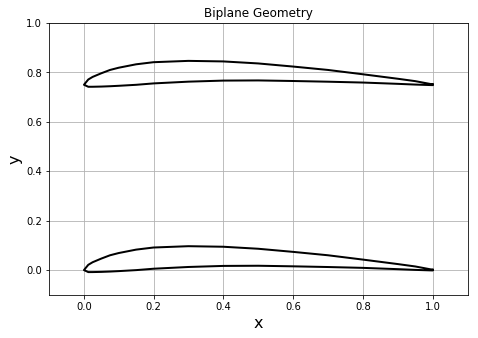

In [21]:
# plot geometry
width = 5
pyplot.figure(figsize=(width*1.5, width))
pyplot.title('Biplane Geometry')
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_m, y_m, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_bi_4, y_bi_4, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 1.0);

### The Panel Method:
Now that our 1st biplane geometry has been created we'll need to incorporate the angle of attack values and eventually solve for lift in order to match Grant's table. To do this we'll use the Panel Method as described in Lesson 11.

Left-over code:

<table><tr>
<td> <img src="BiPlane_Lift_Chord_vs_Gap.JPG" height="500" width="700"> </td>
<td> <img src="Monoplane_vs_Biplane_vs_Triplane.JPG" height="400" width="700"> </td>
</tr></table>

<h3 align = 'center' color=#CC0000>**Figure 1:** Lift vs Gap/Chord (Biplanes) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Figure 2:** Lift vs Angle of Attack (Biplanes & Triplanes)</h3>